# 1. Imports

In [2]:
import numpy as np
from scipy import io
from pathlib import Path
import matplotlib.pyplot as plt

# 3. Read data

In [3]:
DATA_DIR = Path("./binaryalphadigs.mat")

In [4]:
def read_alpha_digit(filepath, size=5, char=0, reshape=False):
    mat = io.loadmat(filepath)
    if size == -1:
        size = mat["dat"][char].shape[0]
    mat = mat["dat"][char][:size]
    if reshape:
        mat = np.array(
            [d.reshape(-1) for d in mat]
        )
    return mat

TypeError: Image data of dtype object cannot be converted to float

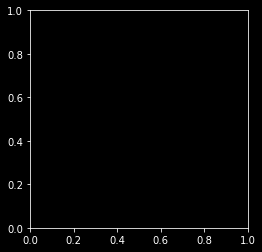

In [35]:
ex = read_alpha_digit(DATA_DIR.__str__(), size=1, char=10, reshape=False)
plt.imshow(ex, cmap="gray")
plt.show()

In [ ]:
X = read_alpha_digit(DATA_DIR.__str__(), size=-1, char=10, reshape=True)
print(X.shape)
print(X[0].shape)

(39, 320)
(320,)


# 4. RBM

In [8]:
class RBM:
    """
        One layer RBM.
        p: input dimension
        q: latent dimension
    """
    
    def __init__(self, p, q, lr=1e-3):
        self.p = p
        self.q = q
        self.lr = lr
        self.W = np.random.randn(p, q) * 1e-1
        self.a = np.random.randn(p)
        self.b = np.random.randn(q)
    
    def P_entree_sortie(self, h):
        """
        p(v_i=1|h)
        """
        return self.W @ h + self.a
    
    def P_sortie_entree(self, v):
        """
        p(h_j|v)
        """
        return v @ self.W + self.b

    def sample_v(self, x):
        """Sample v using Gibbs sampling

        Args:
            x (array): vector

        Returns:
            array: v sampled from p
        """
        # init:
        v = x
        h = np.array([0 for i in range(self.q)])
        
        for i, p in enumerate(self.P_sortie_entree(v)):
            if np.random.uniform(0, 1) < p:
                h[i] = 1
            else:
                h[i] = 0
        
        for i, p in enumerate(self.P_entree_sortie(h)):
            if np.random.uniform(0, 1) < p:
                v[i] = 1
            else:
                v[i] = 0
        
        return v
    
    def get_loss(self, X):
        pass  # TODO : to implement
    
    def fit(self, X, n_epochs, batch_size):
        n = X.shape[0]
        num_batches = n // batch_size
        for epoch in range(n_epochs):
            X = np.random.shuffle(X)
            for batch in range(num_batches):
                X_batch = X[batch * batch_size: (batch + 1) * batch_size, :]
                self.fit_batch(X_batch)
            print(f"EPOCH {epoch} : Loss = {self.get_loss(X)}")
    
    def fit_batch(self, X):
        for i in range(X.shape[0]):  # TODO : Replace the for loop with matrix multiplication.
            x = X[i, :]
            self.fit_one(x)
    
    def fit_one(self, x):
        """
        [Temporary]
        Compute the gradient d Loss / d theta using one single x.

        Args:
            x R^(1 x p) : input
        """
        # Sample v
        v = self.sample_v(x)
        
        p_sortie_entree_x = self.P_sortie_entree(x).reshape(-1, 1)
        p_sortie_entree_v = self.P_sortie_entree(v).reshape(-1, 1)
        x = x.reshape(-1, 1)
        v = v.reshape(-1, 1)
        
        
        # Compute gradients
        dW = np.dot(x.T, p_sortie_entree_x) - np.dot(v.T, p_sortie_entree_v)
        db = np.squeeze(p_sortie_entree_x - p_sortie_entree_v)
        da = np.squeeze(x - v)
        
        # Update weights
        self.W = self.W + self.lr * dW
        self.b = self.b + self.lr * db
        self.a = self.a + self.lr * da

In [37]:
class RBM:
    """
        One layer RBM.
        p: input dimension
        q: latent dimension
    """
    
    def __init__(self, p, q, lr=1e-3):
        self.fitted = False
        self.p = p
        self.q = q
        self.lr = lr
        self.W = np.random.randn(p, q) * 1e-1
        self.a = np.random.randn(p)
        self.b = np.random.randn(q)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def P_entree_sortie(self, h):
        """
        p(v_i=1|h)
        """
        return  self.sigmoid(h @ self.W.T + self.a)
    
    def P_sortie_entree(self, v):
        """
        p(h_j|v)
        """
        return self.sigmoid(v @ self.W + self.b)
    
    def reconstruction_error(self, x):
        h = self.P_sortie_entree(x)
        x_rec = self.P_entree_sortie(h)
        error = np.linalg.norm(x - x_rec)
        error /= x.shape[0]  # Normalize
        return error
    
    def fit(self, X, n_epochs, batch_size):
        n = X.shape[0]
        num_batches = n // batch_size
        for epoch in range(n_epochs):
            np.random.shuffle(X)
            epoch_loss = 0
            for batch in range(num_batches):
                X_batch = X[batch * batch_size: (batch + 1) * batch_size, :]
                
                # Init
                v_0 = X_batch
                
                # Forward
                ph_v_0 = self.P_sortie_entree(v_0)
                h_0 = (np.random.uniform(0, 1, size=(batch_size, self.q)) < ph_v_0) * 1.
                pv_h_0 = self.P_entree_sortie(h_0)
                v_1 = (np.random.uniform(0, 1, size=(batch_size, self.p)) < pv_h_0) * 1.
                ph_v_1 = self.P_sortie_entree(v_1)

                
                # Backward
                da = np.sum(v_0 - v_1, axis=0)
                db = np.sum(ph_v_0 - ph_v_1, axis=0)
                dW = v_0.T @ ph_v_0 - v_1.T @ ph_v_1
                
                # Update
                alpha = self.lr / batch_size
                self.W += alpha * dW
                self.b += alpha * db
                self.a += alpha * da
                
                # Dans l'idéal, il faudrait afficher la log-vraissemblance à chaque étape, mais on ne sais pas la calculer !! Donc on va simplement utiliser une métrique empirique : l'erreur de reconstruction
                epoch_loss += self.reconstruction_error(X_batch)
            print(f"Epoch [{epoch}] - Loss: {epoch_loss}")
        self.fitted = True
    
    def sample(self, nb_iter_gibbs, nb_images=1, image_size=(20, 16)):
        images = []
        for i in range(nb_images):
            # Init
            h_0 = .5 * np.ones(self.p)
            v = np.random.uniform(0, 1, size=(1, self.p)) < h_0
            
            for j in range(nb_iter_gibbs):
                h = np.random.uniform(0, 1, size=(1, self.q)) < self.P_sortie_entree(v)
                v = np.random.uniform(0, 1, size=(1, self.p)) < self.P_entree_sortie(h)
            
            image = v.reshape(image_size)
            
            images.append(image)
        
        return images

NB_INPUT = X.shape[1]
NB_LATENT = 500
LR = 1e-1
N_EPOCH = 100
BATCH_SIZE = 32

model = RBM(p=NB_INPUT, q=NB_LATENT, lr=LR)
model.fit(X=X, n_epochs=N_EPOCH, batch_size=BATCH_SIZE)

Epoch [0] - Loss: 1.52134776916895
Epoch [1] - Loss: 1.610571316898199
Epoch [2] - Loss: 1.3960648235016637
Epoch [3] - Loss: 1.2865442748287077
Epoch [4] - Loss: 1.2345201840153837
Epoch [5] - Loss: 1.1891034372151603
Epoch [6] - Loss: 1.1690159002291376
Epoch [7] - Loss: 1.1529673915194858
Epoch [8] - Loss: 1.1206712690117544
Epoch [9] - Loss: 1.1009773602483188
Epoch [10] - Loss: 1.0760390838005027
Epoch [11] - Loss: 1.0575181336995716
Epoch [12] - Loss: 1.052040774363231
Epoch [13] - Loss: 1.0128286386063627
Epoch [14] - Loss: 1.004445287598604
Epoch [15] - Loss: 0.9913486048017499
Epoch [16] - Loss: 0.9623889996193998
Epoch [17] - Loss: 0.951024538373759
Epoch [18] - Loss: 0.9330415696090741
Epoch [19] - Loss: 0.9077788133944863
Epoch [20] - Loss: 0.9087898321667673
Epoch [21] - Loss: 0.8894056128526519
Epoch [22] - Loss: 0.8692337764657119
Epoch [23] - Loss: 0.8596463125617989
Epoch [24] - Loss: 0.8616464137829315
Epoch [25] - Loss: 0.8390957882077585
Epoch [26] - Loss: 0.8369181

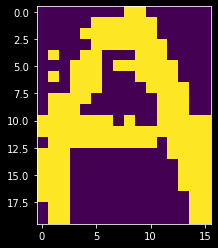

In [39]:
plt.imshow(model.sample(nb_iter_gibbs=100, nb_images=10)[6] * 1.)